In [1]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [2]:
maf = pd.read_csv('../key_files/maf_all_samples_last_gen.csv')

In [3]:
maf.columns = ['MAF']

In [4]:
wd = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lfmm_full_last_gen//lfmm_fullresults_all_k/'

In [5]:
pwd - P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen'

In [9]:
biovar = 'bio12'

In [ ]:
lfmm = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lfmm_full_last_gen/lfmm_fullresults_all_k/lfmm_{biovar}_k16_results.csv'


In [10]:
lfmm = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lfmm_full_last_gen/lfmm_fullresults_all_k/lfmm_{biovar}_k16_results.csv'

lfmm = pd.read_csv(lfmm)

In [11]:
lfmm

,snp_id,p_value,significant,block
0,1_346,0.006284,False,1_0
1,1_353,0.160194,False,1_0
2,1_363,0.428330,False,1_0
3,1_395,0.166031,False,1_0
4,1_396,0.166031,False,1_0
...,...,...,...,...
1048630,5_26975078,0.370729,False,5_3110
1048631,5_26975121,0.757991,False,5_3110
1048632,5_26975148,0.757991,False,5_3110
1048633,5_26975272,0.730227,False,5_3110


In [12]:
lfmm = pd.concat([lfmm, maf['MAF']],axis=1)

In [13]:
lfmm

,snp_id,p_value,significant,block,MAF
0,1_346,0.006284,False,1_0,0.288067
1,1_353,0.160194,False,1_0,0.077929
2,1_363,0.428330,False,1_0,0.092449
3,1_395,0.166031,False,1_0,0.078113
4,1_396,0.166031,False,1_0,0.078113
...,...,...,...,...,...
1048630,5_26975078,0.370729,False,5_3110,0.169091
1048631,5_26975121,0.757991,False,5_3110,0.069410
1048632,5_26975148,0.757991,False,5_3110,0.069410
1048633,5_26975272,0.730227,False,5_3110,0.466354


In [14]:
lfmm.to_csv('lfmm_results_all_samples_k16_wmaf_bio12.csv',index=None)

In [15]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen/'

In [16]:
## create a dir 
# create sbatch files to submit on cedar server
shfiles = []

seed = random.randint(1,100000000)
file = 'wza.sh'
cmd = f'python general_WZA_script_mod_polynomial_order7.py \
        --correlations lfmm_results_all_samples_k16_wmaf_bio12.csv \
        --summary_stat p_value \
        --window block \
        --output wza_results_lfmm_bio12_poly7.csv \
        --sep ","'
text = f'''#!/bin/bash
#SBATCH --job-name=wza
#SBATCH --time=1:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen
{cmd}


'''
with open(file, 'w') as o:
    o.write("%s" % text)
shfiles.append(file)

In [17]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 57171


In [18]:
biovar = 'bio1'

In [19]:
wza_lfmm = pd.read_csv('wza_results_lfmm_bio12_poly7.csv')

In [10]:
p0_average_seed_mix = pd.read_csv('../key_files/p0_average_seed_mix.csv')
snps_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')
p0_average_seed_mix = pd.concat([p0_average_seed_mix,snps_dict ], axis=1)

In [11]:
p0_average_seed_mix.columns

Index(['0', 'id', 'pos', 'chrom', 'maf05filter',
       'total_alleles05filter_firstgen', 'total_alleles05filter_lastgen'],
      dtype='object')

In [12]:
neutral_blocks = wza_lfmm[wza_lfmm['gene'].isin(neutral_blocks)].sort_values('Z_pVal').tail(10)['gene'].reset_index()

NameError: name 'neutral_blocks' is not defined

In [ ]:
neutral_blocks

In [ ]:
neutral_blocks['type'] = 'neutral'

adaptive_blocks  = wza_lfmm.dropna().sort_values('Z_pVal').head(10)['gene'].reset_index()
adaptive_blocks['type'] = 'adaptive'

blocks_to_plot = pd.concat([neutral_blocks, adaptive_blocks],axis=0).drop('index', axis=1)

blocks_to_plot.columns = ['block', 'type']

blocks_to_plot.to_csv('blocks_to_plot.csv',index=None)

In [ ]:
adaptive_blocks

In [ ]:
adaptive_blocks['gene'].values

In [ ]:
initial_freq_ab = {}
for i in adaptive_blocks['gene'].values:
    snps = dict_blocks[i]
    meanp0 = p0_average_seed_mix[p0_average_seed_mix['id'].isin(snps)]['0'].mean()
    initial_freq_ab[i] = meanp0

In [ ]:
initial_freq_ab

In [ ]:
2_1265

In [ ]:
'2_1265': 0.05633901086956521,

In [ ]:
initial_freq_blocks = {}
for i in wza_lfmm['gene'].values:
    snps = dict_blocks[i]
    meanp0 = p0_average_seed_mix[p0_average_seed_mix['id'].isin(snps)]['0'].mean()
    initial_freq_blocks[i] = meanp0

In [13]:
neutral_blocks

NameError: name 'neutral_blocks' is not defined

In [107]:
for i in neutral_blocks['gene']:
    print(i)
    print(initial_freq_blocks[i])
    

3_1103
0.06325609274193547
1_1555
0.06220405271084335
1_5039
0.05872527777777773
1_2834
0.05909783136792451
3_1463
0.05698645833333333
3_1308
0.061640241525423724
3_1280
0.05965878040540541
2_2050
0.06014913651315788
1_4969
0.06466621346153845
1_4832
0.05914924405940592


In [94]:
neutral_blocks = []
for i in initial_freq_blocks.keys():
    #print(np.round(initial_freq_blocks[i],2))
    if np.round(initial_freq_blocks[i], 2) == 0.06:
        neutral_blocks.append(i)

In [101]:
wza_lfmm[wza_lfmm['gene'].isin(neutral_blocks)].sort_values('Z_pVal').tail(10)['gene']

7363    3_1103
611     1_1555
4438    1_5039
2010    1_2834
7760    3_1463
7590    3_1308
7559    3_1280
6267    2_2050
4359    1_4969
4208    1_4832
Name: gene, dtype: object

In [20]:
wza_lfmm[wza_lfmm['Z_pVal'].isna()]

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal
1234,1_2123,2026,1,-19.605747,1.000000e+00,NaN
1246,1_2134,2440,8,-1.345135,9.999667e-01,NaN
4572,1_5160,2134,2,0.718231,1.000000e+00,NaN
5406,2_1264,1885,2,-6.916518,9.999999e-01,NaN
5592,2_1434,2005,4,1.386334,9.999971e-01,NaN
5662,2_1498,1870,5,-1.824462,9.999545e-01,NaN
6795,2_576,2845,10,12.941438,9.999801e-01,NaN
7217,2_973,1843,3,-3.679747,9.999983e-01,NaN
10063,3_518,1928,3,-3.890255,9.999992e-01,NaN
10099,3_551,1849,77,11.789533,1.184577e-24,NaN


In [21]:
for i in wza_lfmm[wza_lfmm['Z_pVal'].isna()]['gene'].values:
    result = dict_blocks[i][0].split('_')[0] + ':' + dict_blocks[i][0].split('_')[1] + '-' + dict_blocks[i][-1].split('_')[1]
    print(result)

1:13286158-13459438
1:13994194-14334278
1:29843621-30206922
2:11323342-11533875
2:13295373-13583346
2:14646430-14875394
2:2359861-2624928
2:9718274-9888341
3:4848667-5073869
3:5647315-5830464
4:2189547-2374385
5:1610329-1892264
5:25203505-25378349
5:2680453-2938486
5:6857879-7054791
5:7472176-7709317
5:8439332-8598546
5:9101688-9295378
5:10534963-10783578
5:12989594-13358717
5:13433854-13665203


In [20]:
threshold_value = 0.05 / len(wza_lfmm)

In [21]:
#wza_lfmm[wza_lfmm['Z_pVal']< threshold_value].to_csv('wza_lfmm_significant_blocks.csv',index=None)

NameError: name 'biovar' is not defined

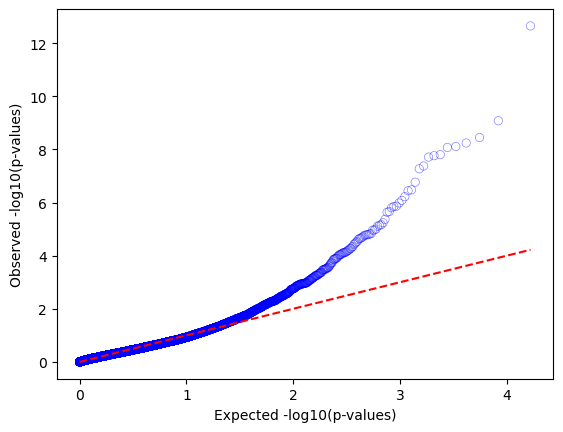

In [9]:
observed_quantiles = -np.log10(np.sort(wza_lfmm['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza_lfmm), 1, len(wza_lfmm)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

In [22]:
import pickle
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [24]:
minval = wza_lfmm.loc[wza_lfmm['Z_pVal']!=0]['Z_pVal'].min()

In [25]:
wza_lfmm.loc[wza_lfmm['Z_pVal']==0, 'Z_pVal'] = minval

In [22]:
wza_lfmm['chrom'] = wza_lfmm['gene'].str.split('_').str[0].astype(int)
wza_lfmm['pos'] = wza_lfmm['gene'].str.split('_').str[1].astype(int)

In [23]:
wza_lfmm.sort_values('Z_pVal').head(7)['gene'].values

array(['3_3245', '5_2197', '4_2292', '2_841', '4_1254', '1_2865', '5_106'],
      dtype=object)

In [24]:
for i in wza_lfmm.sort_values('Z_pVal').head(7)['gene'].values:
    result = dict_blocks[i][0].split('_')[0] + ':' + dict_blocks[i][0].split('_')[1] + '-' + dict_blocks[i][-1].split('_')[1]
    print(result)

3:22281125-22294443
5:19183883-19184375
4:10885078-10885266
2:7667915-7702005
4:8434497-8435553
1:20670028-20670184
5:758173-760864


In [25]:
dict_blocks[i][0].split('_')[0]

'5'

In [26]:
dict_blocks[i][-1].split('_')[1]

'760864'

/tmp/ipykernel_2990586/3791042770.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


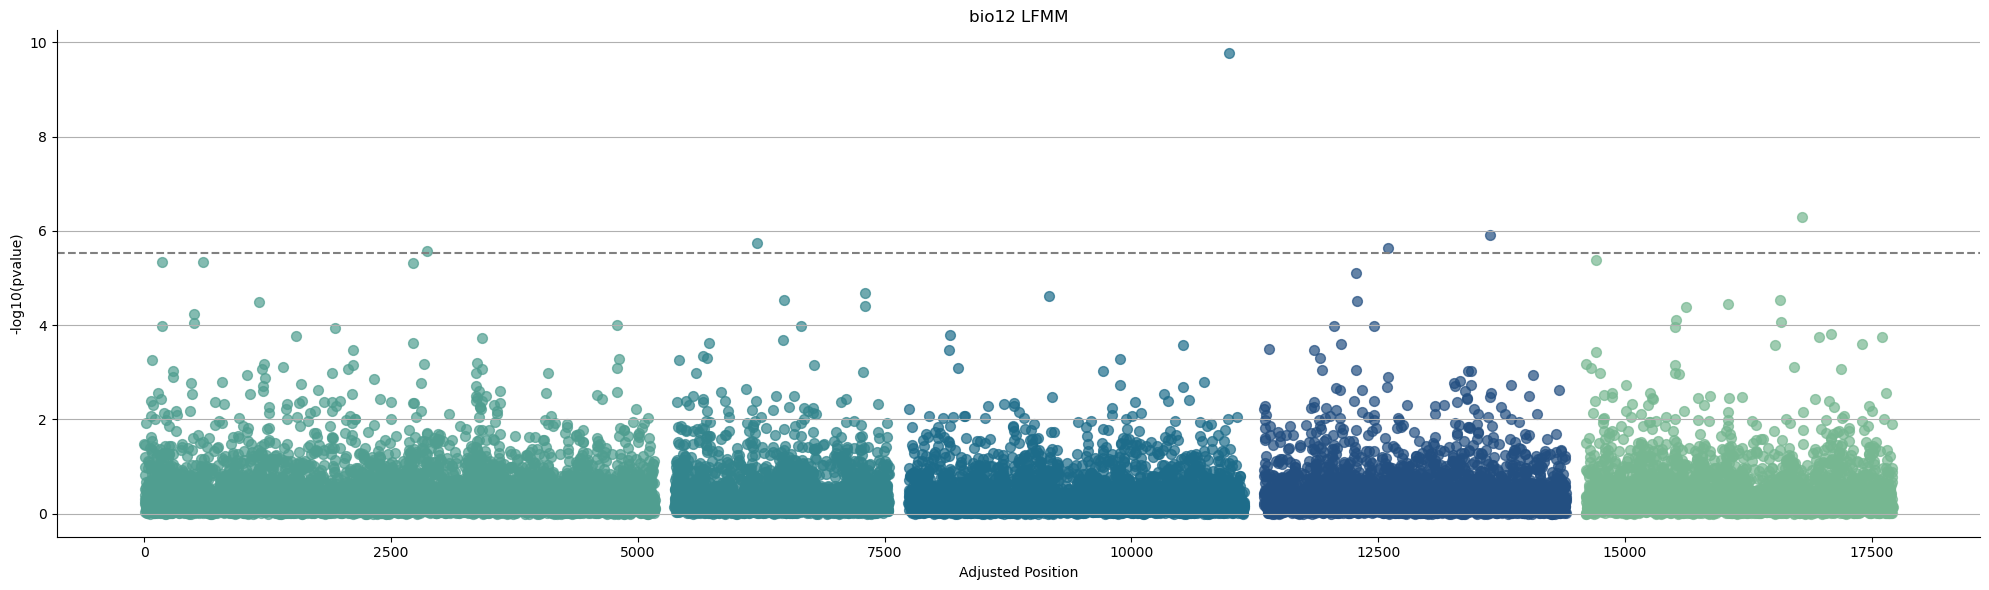

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_lfmm)
threshold = -np.log10(threshold_value)
biovar = 'bio12'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_lfmm['chrom_pos'] = wza_lfmm['chrom'].astype(str) + '_' + wza_lfmm['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_lfmm[['Z_pVal', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Define colors for each chromosome
colors = sns.color_palette("crest", n_colors=5)

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=50
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} LFMM')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]


plt.tight_layout()
plt.savefig(f'manhattan_{biovar}_lfmm.pdf')
plt.savefig(f'manhattan_{biovar}_lfmm.png',dpi=600)
plt.show()

In [ ]:
# Highlight specific genes if needed
genes = ['2_1265']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4164990/690161181.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


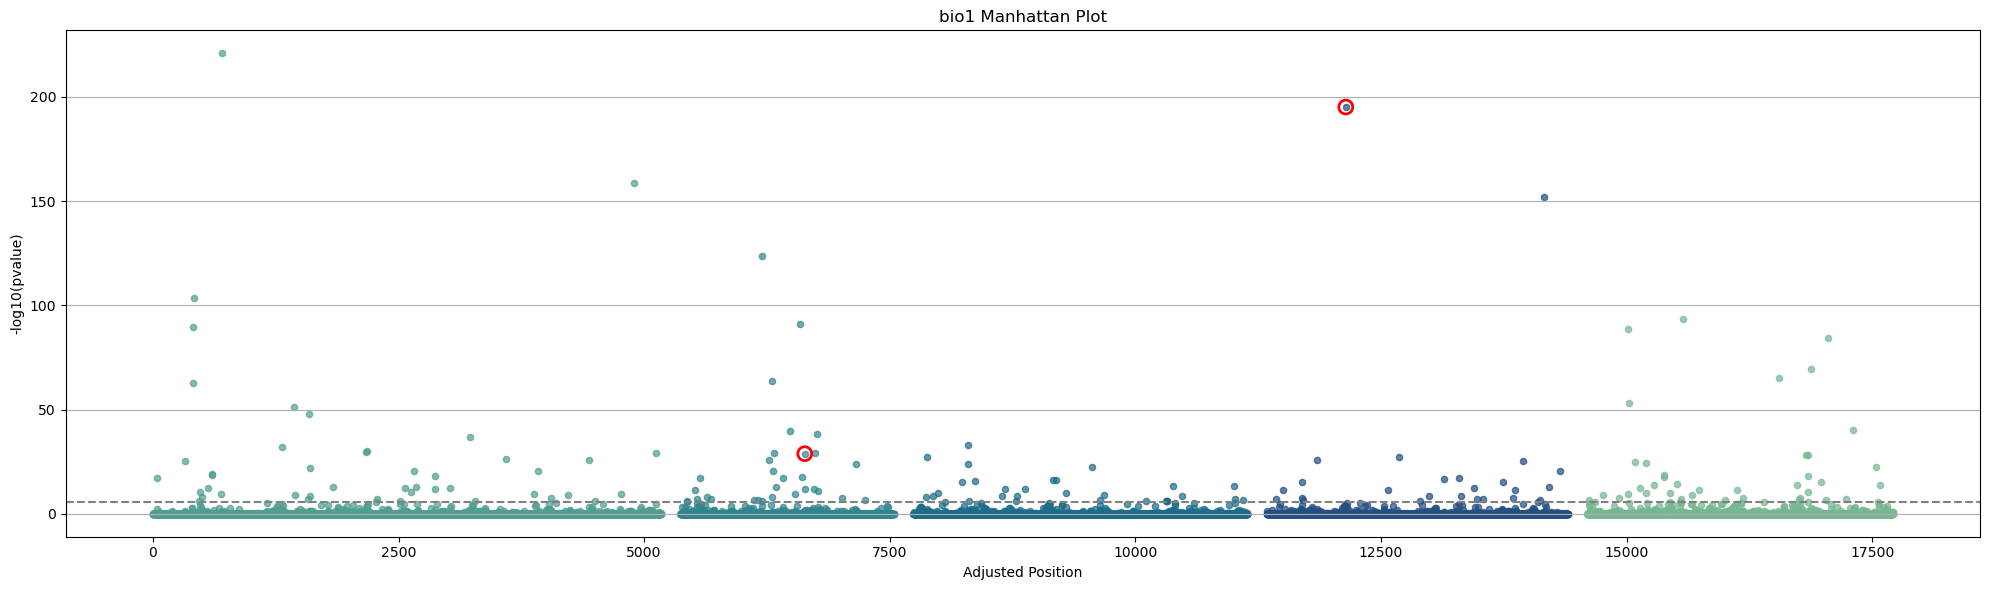

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_lfmm)
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_lfmm['chrom_pos'] = wza_lfmm['chrom'].astype(str) + '_' + wza_lfmm['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_lfmm[['top_candidate_p', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Define colors for each chromosome
colors = sns.color_palette("crest", n_colors=5)

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]


# Highlight specific genes if needed
genes = ['2_1265', '4_801']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.show()

/tmp/ipykernel_3972733/450657511.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


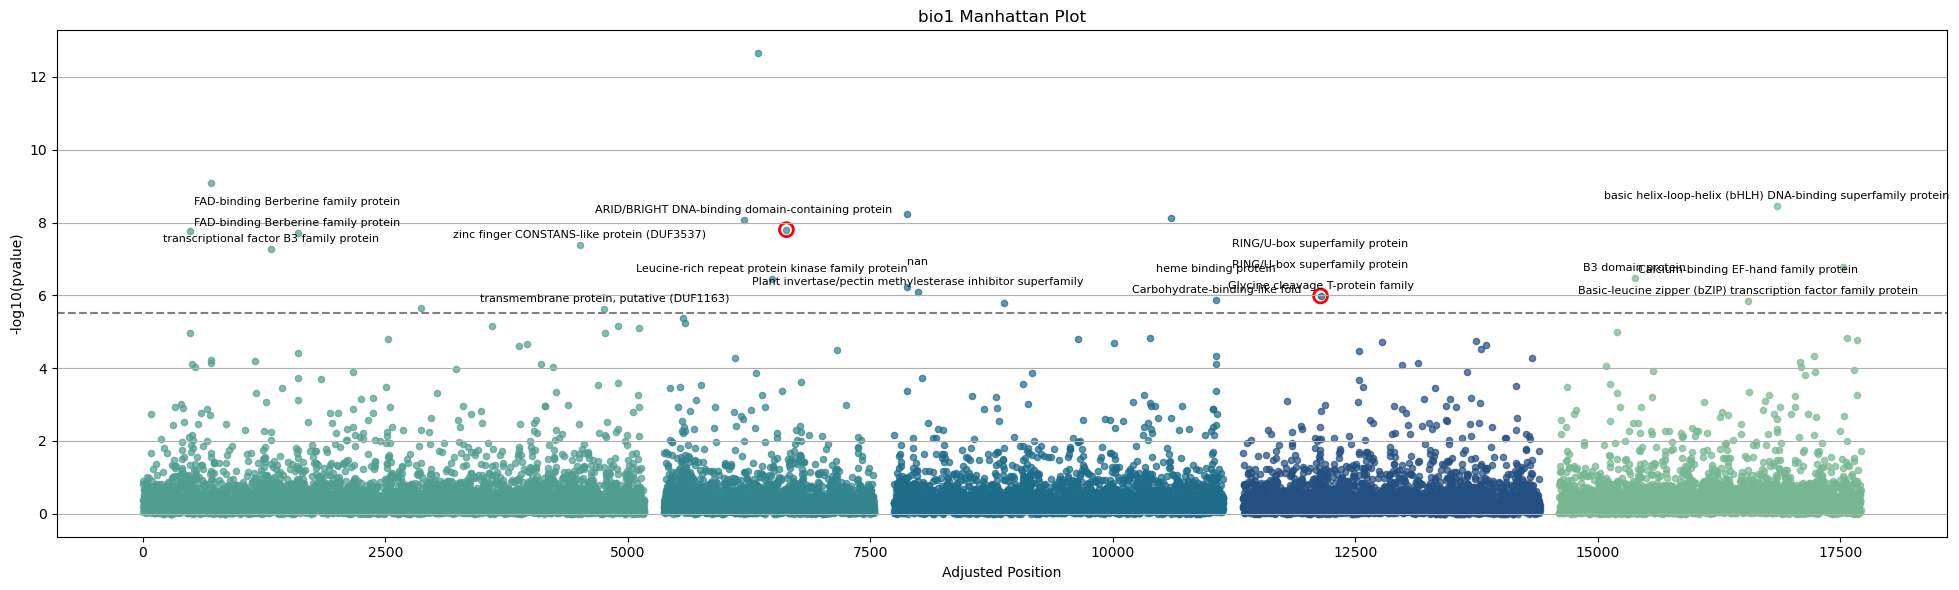

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_lfmm)
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_lfmm['chrom_pos'] = wza_lfmm['chrom'].astype(str) + '_' + wza_lfmm['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_lfmm[['Z_pVal', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Define colors for each chromosome
colors = sns.color_palette("crest", n_colors=5)

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]

# Merge significant blocks with the annotation dataframe based on chrom_pos and block
annotated_blocks = significant_blocks.merge(small, left_on='chrom_pos', right_on='block', how='inner')

# Annotate the significant points with 'description1' and space annotations vertically
for chrom_pos, group in annotated_blocks.groupby('chrom_pos'):
    # Sort the group to ensure consistent spacing
    group = group.sort_values(by='description1')
    vertical_offset = 0  # Start the vertical offset at 0
    for i, row in group.iterrows():
        plt.annotate(
            row['description1'], 
            (row['adjusted_position'], row['-log10(pvalue)']),
            textcoords="offset points",  # Specify the offset point for the text
            xytext=(0, 5 + vertical_offset),  # Increment vertical offset for each annotation
            ha='center',    # Align horizontally to center
            fontsize=8,
            color='black'
        )
        vertical_offset += 15  # Increase vertical offset for the next annotation

# Highlight specific genes if needed
genes = ['2_1265', '4_801']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.show()


/tmp/ipykernel_3972733/1450895180.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


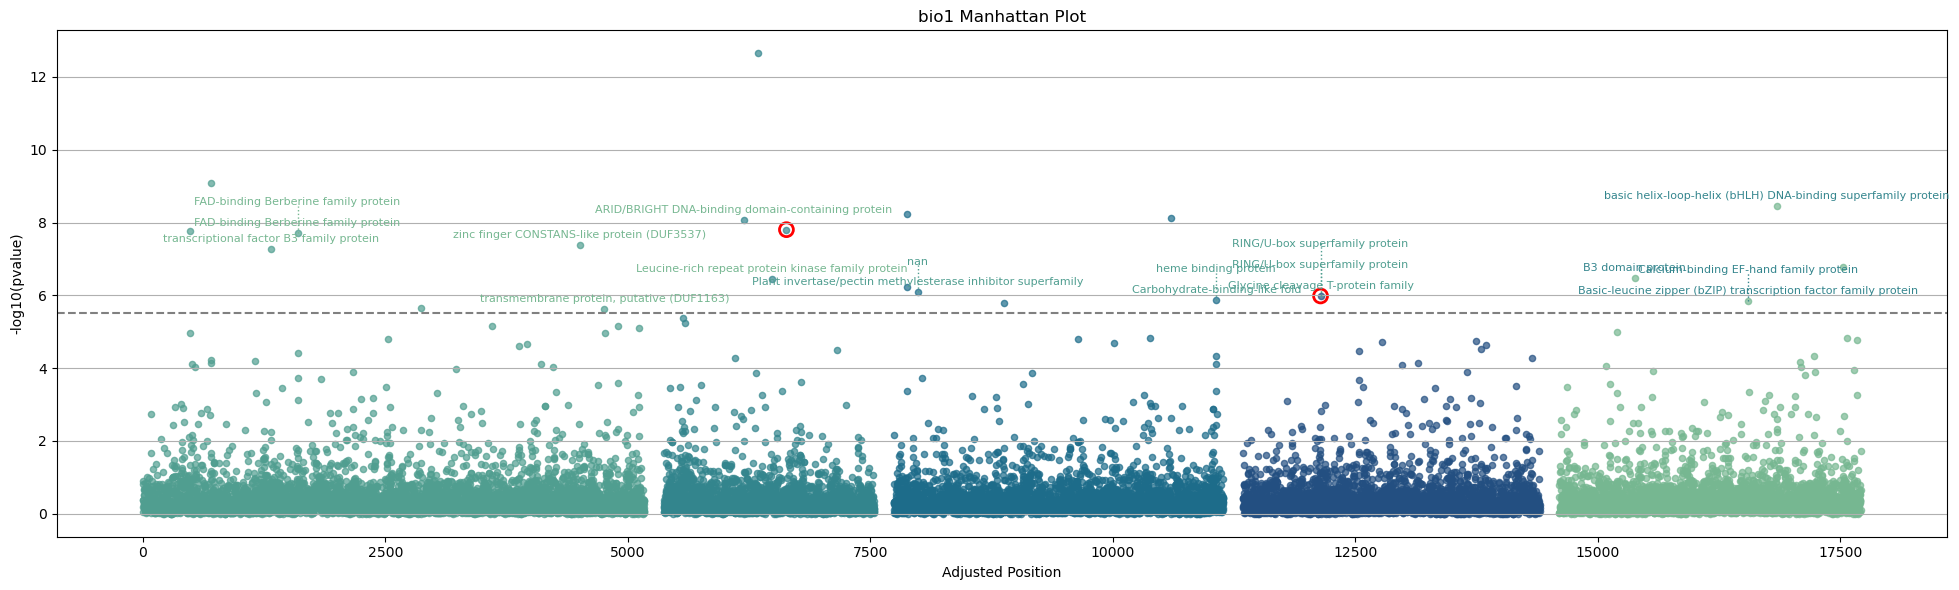

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_lfmm)
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_lfmm['chrom_pos'] = wza_lfmm['chrom'].astype(str) + '_' + wza_lfmm['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_lfmm[['Z_pVal', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Define colors for each chromosome or block
colors = sns.color_palette("crest", n_colors=len(df['chromosome'].unique()))  # Assign a unique color per chromosome

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]

# Merge significant blocks with the annotation dataframe based on chrom_pos and block
annotated_blocks = significant_blocks.merge(small, left_on='chrom_pos', right_on='block', how='inner')

# Annotate the significant points with 'description1', space annotations, and color-code them
for chrom_pos, group in annotated_blocks.groupby('chrom_pos'):
    group = group.sort_values(by='description1')
    vertical_offset = 0  # Start the vertical offset at 0
    
    # Color for this block
    color = colors[chromosome_offsets[group['chromosome'].iloc[0]] % len(colors)]

    for i, row in group.iterrows():
        # Add the annotation
        plt.annotate(
            row['description1'], 
            (row['adjusted_position'], row['-log10(pvalue)']),
            textcoords="offset points",  
            xytext=(0, 5 + vertical_offset),  # Offset vertically for each annotation
            ha='center',
            fontsize=8,
            color=color  # Use the same color for annotation
        )
        
        # Draw a line connecting the point to the annotation
        plt.plot(
            [row['adjusted_position'], row['adjusted_position']],  # X coordinates (same X)
            [row['-log10(pvalue)'], row['-log10(pvalue)'] + (vertical_offset / 20)],  # Y coordinates
            color=color, linewidth=1, linestyle='dotted'
        )
        
        vertical_offset += 15  # Increase vertical offset for the next annotation

# Highlight specific genes if needed
genes = ['2_1265', '4_801']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.show()


/tmp/ipykernel_3972733/3243139160.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


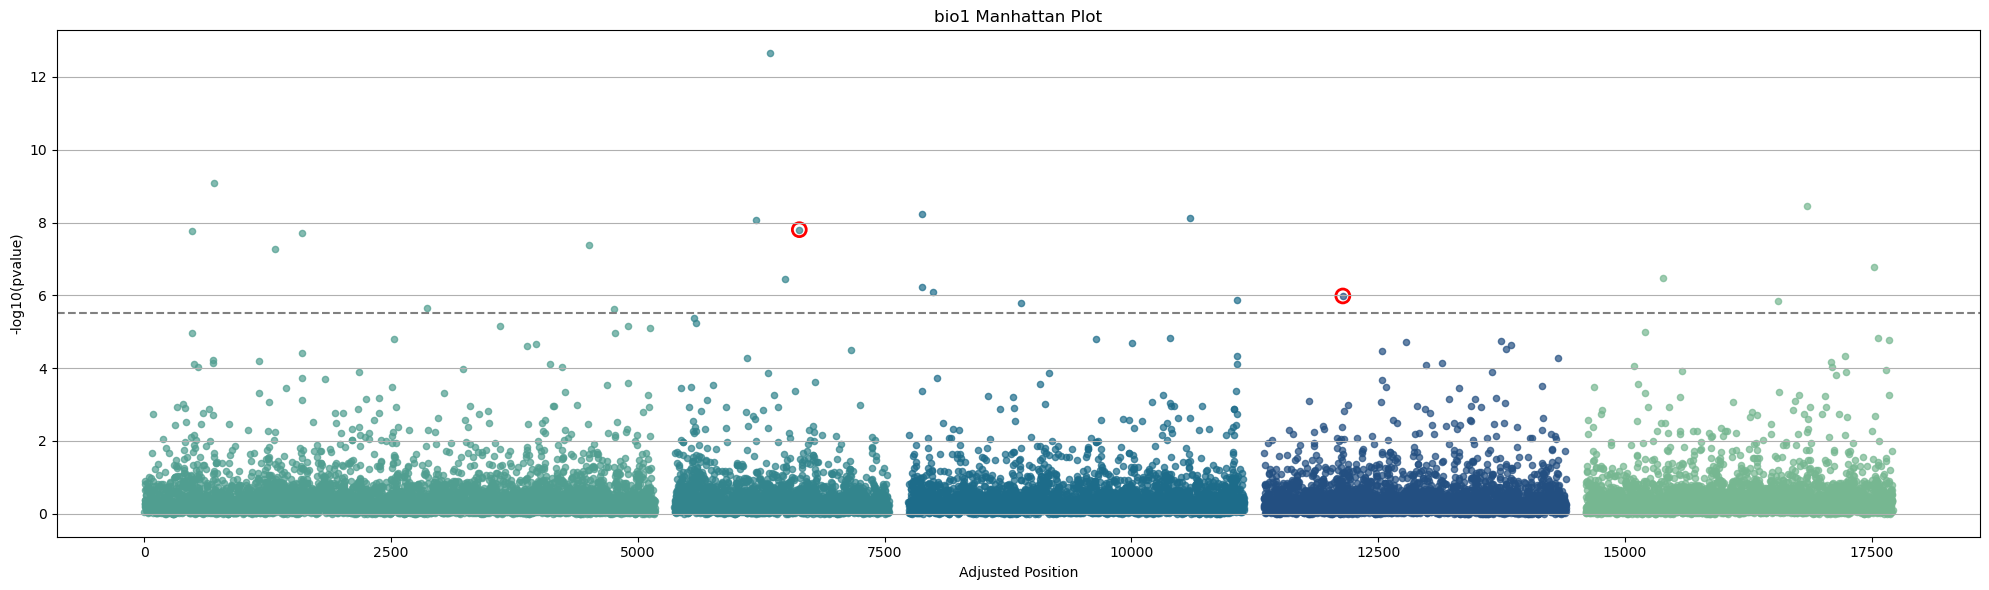

In [27]:
threshold_value = 0.05 / len(wza_lfmm)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza_lfmm[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 20)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')  # Set the title
plt.grid(axis='y')


#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )
# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')

# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.show()


In [51]:
wza_kendall = pd.read_csv('wza_kendalltau_results_bio1.csv').reset_index()

In [52]:
wza_kendall['chrom'] = wza_kendall['gene'].str.split('_').str[0].astype(int)
wza_kendall['pos'] = wza_kendall['gene'].str.split('_').str[1].astype(int)

In [53]:
threshold_value = 0.05 / len(wza_kendall)

In [54]:
wza_kendall[wza_kendall['Z_pVal']< threshold_value].to_csv('wza_kendall_significant_blocks.csv',index=None)

In [ ]:
wza_kendall

In [ ]:
gene - the name of the window
SNPs - the number of SNPs in this window
hits - the number of SNPs in the 99th percentile (not used for anything, just good to know)
Z - the Z score calculated for the gene
top_candidate_p - the result of the top-candidate method of Yeaman et al (2016 - Science)
LA - an indicator of whether the gene is causal for local adaptation
position - the average position of all SNPs in the window
Z_pVal - the p-value of the Z score (This is the WZA score)


/tmp/ipykernel_894693/1995763944.py:1: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza_kendall['Z_pVal'].values))


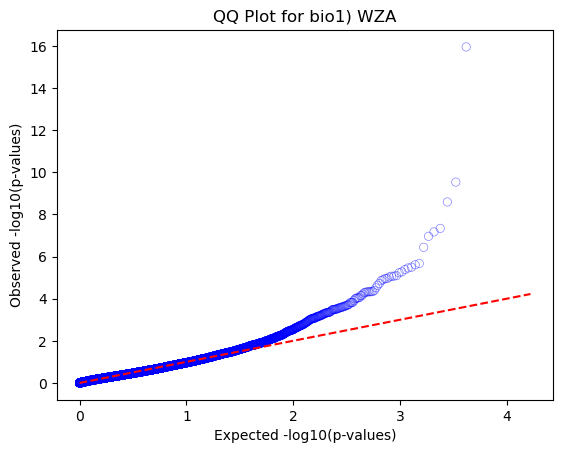

In [48]:
observed_quantiles = -np.log10(np.sort(wza_kendall['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza_kendall), 1, len(wza_kendall)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_894693/2348446781.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


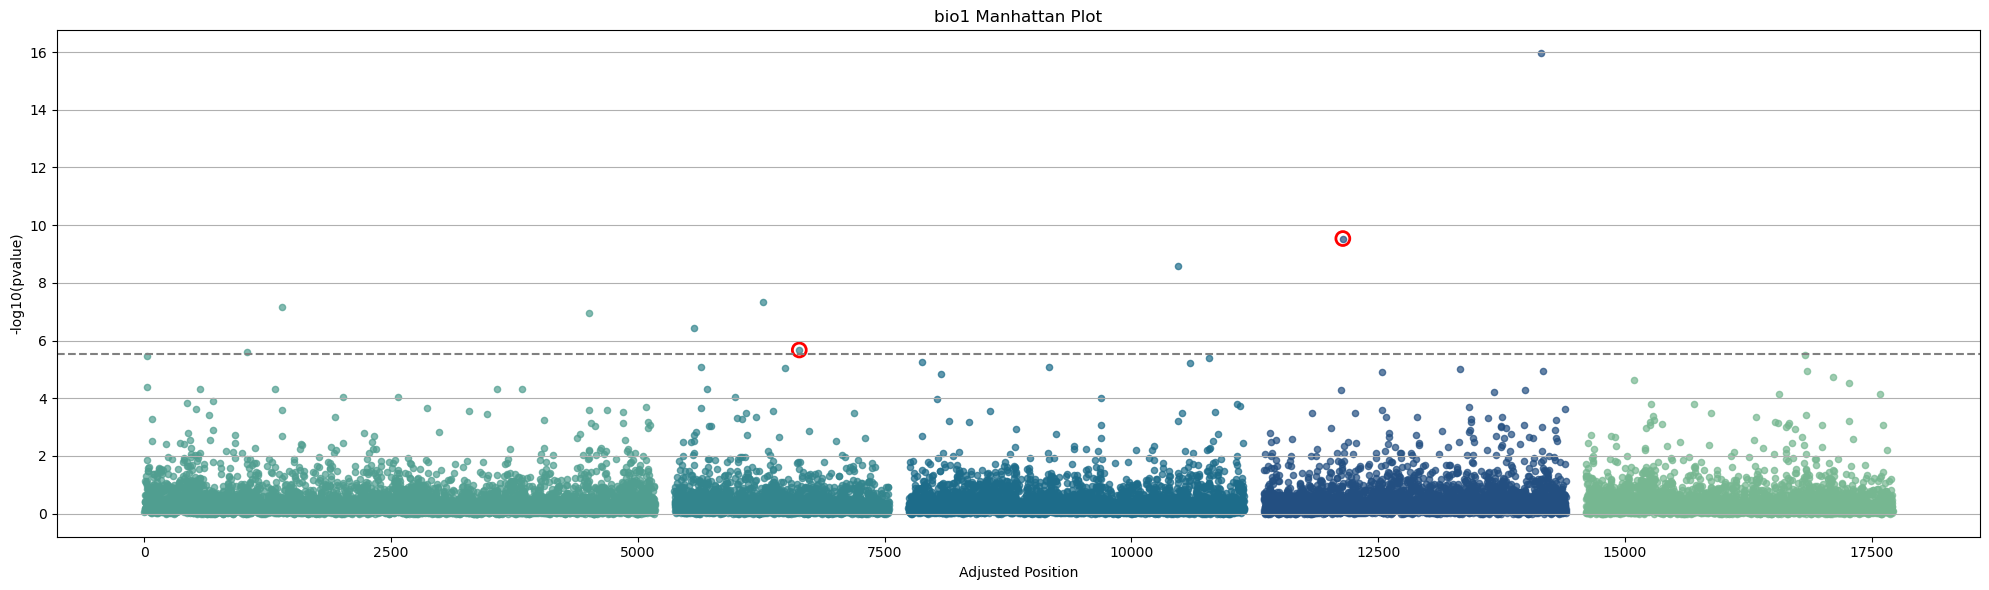

In [57]:
threshold_value = 0.05 / len(wza_kendall)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza_kendall[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 20)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')  # Set the title
plt.grid(axis='y')

# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )


# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_3175312/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


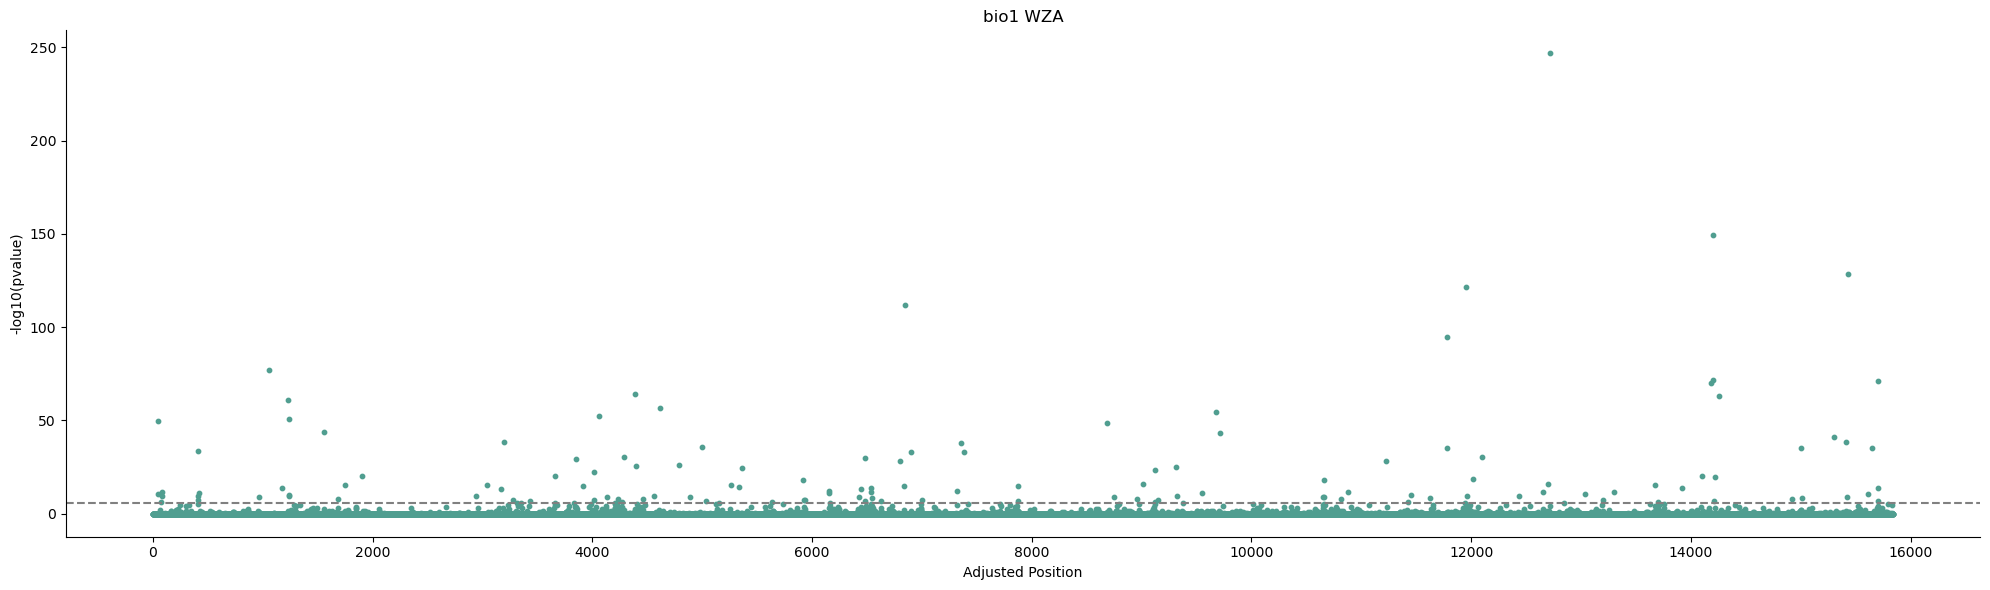

In [50]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()